In [1]:
## Tensorflow model

from keras.models import Sequential
from keras.utils import np_utils
from keras.layers.core import Dense, Activation, Dropout
from keras.layers import Conv2D, MaxPool2D, MaxPool1D, Flatten, BatchNormalization, Reshape, Rescaling, Normalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam, SGD
import keras
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn.exceptions as ske
import tensorflow as tf
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler as ROS
import pandas as pd
import numpy as np
import warnings
import datetime
from PIL import Image
import os

img_size_x = 640
img_size_y = 490
batch_size = 8

warnings.filterwarnings("ignore")

#print(tf.config.list_physical_devices('GPU'))
#print(tf.config.list_logical_devices('GPU'))

In [2]:
#dataset
rtx_3060 = '/device:GPU:0'
oversampler = ROS(sampling_strategy='auto')
imgList = []
data = pd.DataFrame([])
data_dir = 'C:/Users/lucas/Downloads/CS229-master/CS229-master/CK+'

print('Creating dataset')
i = 0

"""for dirname, _, filenames in os.walk('C:/Users/lucas/Downloads/CS229-master/CS229-master/CK+'):
    for filename in filenames:
        imgName = os.path.join(dirname, filename)
        imgList.append(imgName)"""
"""for file in imgList:
    i = i+1
    print(f"image {i} out of {len(imgList)}")
    img = Image.open(file)
    value = np.asarray(img)
    value = value.flatten()
    if 'anger' in file:
        value = np.insert(value, 0, 0)
    elif 'disgust' in file:
        value = np.insert(value, 0, 1)
    elif 'fear' in file:
        value = np.insert(value, 0, 2)
    elif 'happiness' in file:
        value = np.insert(value, 0, 3)
    elif 'sadness' in file:
        value = np.insert(value, 0, 4)
    elif 'surprise' in file:
        value = np.insert(value, 0, 5)
    elif 'neutral' in file:
        value = np.insert(value, 0, 6)
    else:
        print("bad data")
    #print(value)
    value = pd.DataFrame(value)
    value = value.transpose()
    #print(value)
    data = data.append(value)"""
train_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_size_x, img_size_y),
  batch_size=batch_size,
  color_mode='grayscale')
val_ds = keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_size_x, img_size_y),
  batch_size=batch_size,
  color_mode='grayscale')
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

Creating dataset
Found 848 files belonging to 7 classes.
Using 679 files for training.
Found 848 files belonging to 7 classes.
Using 169 files for validation.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 640, 490, 32)      320       
                                                                 
 conv2d_1 (Conv2D)           (None, 640, 490, 64)      18496     
                                                                 
 batch_normalization (BatchN  (None, 640, 490, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 320, 245, 64)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 320, 245, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 320, 245, 128)     2

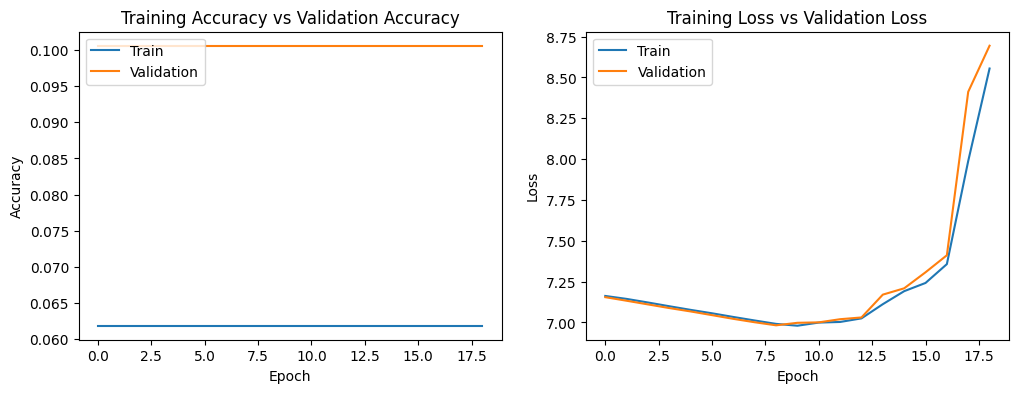

In [3]:
#Training
with tf.device(rtx_3060):
    # convert list of labels to binary class matrix
    # Here's a Deep Dumb MLP (DDMLP)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(640,490,1)))
    model.add(Conv2D(64,(3,3), padding='same', activation='relu' ))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128,(5,5), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
        
    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(512,(3,3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten()) 
    model.add(Dense(256,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))
        
    model.add(Dense(512,activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.25))

    model.add(Dense(1, activation='softmax'))

    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy',
                         mode='max', verbose=1, save_best_only=True)
    # we'll use categorical xent for the loss, and adam as the optimizer
    model.compile(loss='categorical_crossentropy',optimizer=SGD(learning_rate=0.001),
                  metrics = ['accuracy'])
    model.summary()
    print("Training...")
    history = model.fit(train_ds,validation_data=val_ds,epochs=50,callbacks=[es,mc],verbose=2)
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    fig.set_size_inches(12,4)

    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Training Accuracy vs Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Training Loss vs Validation Loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    """print("Generating test predictions...")
    model = load_model('best_model.h5')
    preds=model.predict(X_test)
    yhat = np.argmax(preds,axis=1)
    test_labels = np.argmax(y_test,axis=1)

    def write_preds(preds, fname):
        pd.DataFrame({"ImageId": list(range(1,len(preds)+1)), "Label": preds}).to_csv(fname, index=False, header=True)
    now = str(datetime.datetime.today()).replace('.','_')
    now = now.replace(':','_')
    write_preds(yhat,"preds "+now+".csv")

    
    target_names = ['Angry','Disgust','Fear','Happiness','Sad','Surprise','Neutral']
    print("Classification Report:")
    print(classification_report(test_labels,yhat,target_names=target_names))

    plt.show()"""

PYTORCH model

In [1]:
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler as ROS
import pandas as pd
import numpy as np
import warnings
import datetime
from PIL import Image
import os
import torch.nn as nn
import torch
import torch.utils.data.dataloader as dataloader
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchmetrics import Accuracy, ConfusionMatrix
from torch import optim
from torchsummary import summary
from torch.nn import functional as F
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import sklearn.exceptions as ske
img_size_x = 640
img_size_y = 480

warnings.filterwarnings("ignore")

In [2]:
#dataset
batch_size = 8
data_dir = 'C:\\Users\\lucas\\Downloads\\CS229-master\\CS229-master\\CK+'
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Resize((img_size_x,img_size_y)),
     transforms.Normalize((0.5,), (0.5,),),
     transforms.Grayscale()])
#generator1 = torch.Generator().manual_seed(42)
dataset = torchvision.datasets.ImageFolder(root=data_dir,transform=transform)
#print(dataset.samples)
print(len(dataset.samples))
img_count = 848
train_count = int(0.7 * img_count)+1
valid_count = int(0.3 * img_count)
print(train_count)
print(valid_count)
valset, trainset = torch.utils.data.random_split(dataset, (valid_count,train_count))
trainloader = dataloader.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True)
images, labels = next(iter(trainloader))
print(images[0])
#valset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
valloader = dataloader.DataLoader(valset, batch_size=batch_size,shuffle=False)

848
594
254
tensor([[[-0.5960, -0.0823,  0.3268,  ..., -0.3987, -0.8627, -0.9999],
         [-0.6036, -0.0671,  0.3480,  ..., -0.4504, -0.8728, -0.9940],
         [-0.7615, -0.4387, -0.2034,  ..., -0.6911, -0.9271, -0.9945],
         ...,
         [-0.9822, -0.8507, -0.5657,  ...,  0.2186,  0.0638,  0.0185],
         [-0.9850, -0.8280, -0.5408,  ...,  0.2109,  0.0688,  0.0351],
         [-0.9960, -0.9450, -0.7764,  ...,  0.2287,  0.0510, -0.0353]]])


In [3]:
#model
class Residual(nn.Module): 
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1,
                                   stride=strides)
        self.conv2 = nn.LazyConv2d(num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                                       stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.LazyBatchNorm2d()
        self.bn2 = nn.LazyBatchNorm2d()

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

class ResNet():
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2))
            else:
                blk.append(Residual(num_channels))
        return nn.Sequential(*blk)
    def __init__(self, arch, num_classes=10):
        self.model = nn.Sequential(self.b1())
        for i, b in enumerate(arch):
            self.model.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.model.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(num_classes)))

class ResNet18(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((2, 64), (2, 128), (2, 256), (2, 512)), num_classes)

class ResNet26(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((4, 64), (4, 128), (4, 256), (4, 512)), num_classes)

class ResNet32(ResNet):
    def __init__(self, num_classes=10):
        super().__init__(((5, 64), (5, 128), (6, 256), (6, 512)), num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [4]:
RN18 = ResNet18(num_classes=7).model
RN18.to(device)
summary(RN18,(1,img_size_x,img_size_y))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 320, 240]           3,200
       BatchNorm2d-2         [-1, 64, 320, 240]             128
              ReLU-3         [-1, 64, 320, 240]               0
         MaxPool2d-4         [-1, 64, 160, 120]               0
            Conv2d-5         [-1, 64, 160, 120]          36,928
       BatchNorm2d-6         [-1, 64, 160, 120]             128
            Conv2d-7         [-1, 64, 160, 120]          36,928
       BatchNorm2d-8         [-1, 64, 160, 120]             128
          Residual-9         [-1, 64, 160, 120]               0
           Conv2d-10         [-1, 64, 160, 120]          36,928
      BatchNorm2d-11         [-1, 64, 160, 120]             128
           Conv2d-12         [-1, 64, 160, 120]          36,928
      BatchNorm2d-13         [-1, 64, 160, 120]             128
         Residual-14         [-1, 64, 1

In [5]:
#training
criterion = nn.CrossEntropyLoss()
#criterion.to(device)
optimizer = optim.SGD(RN18.parameters(), lr=0.01)
#optimizer.to(device)
optimizer.zero_grad()
train_loss_history = []
val_loss_history = []
val_acc_history = []
best_acc = 0.0
for epoch in range(50):
    train_loss = 0.0
    val_loss = 0.0
    val_acc = 0.0
    for images, labels in trainloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = RN18(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        train_loss += loss.item()
    train_loss = train_loss/len(trainloader)
    train_loss_history.append(train_loss)
    for images, labels in valloader:
        # get the inputs; data is a list of [inputs, labels]
        images = images.to(device)
        labels = labels.to(device)
        # forward + backward + optimize
        outputs = RN18(images)
        outputs = outputs.to(device)
        loss = criterion(outputs, labels)

        # print statistics
        val_loss += loss.item()
        acc = Accuracy('multiclass',num_classes=7).to(device)
        val_acc += acc(outputs,labels)
    val_loss = val_loss/len(valloader)
    val_loss_history.append(val_loss)
    val_acc = val_acc/len(valloader)
    if val_acc > best_acc:
        print(f"val_acc improved from {best_acc} to {val_acc}, saving model")
        best_acc = val_acc
        torch.save({
                    'epoch': epoch+1,
                    'model_state_dict': RN18.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss': criterion,
                    }, 'best_model.pt')
    val_acc_history.append(val_acc)
    print(f' epoch[{epoch + 1}] losses train: {train_loss} val: {val_loss} val acc: {val_acc}')

val_acc improved from 0.0 to 0.6380208134651184, saving model
 epoch[1] losses train: 1.3251634450753529 val: 1.3387798890471458 val acc: 0.6380208134651184
val_acc improved from 0.6380208134651184 to 0.6497395634651184, saving model
 epoch[2] losses train: 1.268673175573349 val: 1.2350737228989601 val acc: 0.6497395634651184
 epoch[3] losses train: 1.2328838010629017 val: 1.3215239783748984 val acc: 0.6497395634651184
 epoch[4] losses train: 1.254915550549825 val: 1.5039297193288803 val acc: 0.3333333432674408
 epoch[5] losses train: 1.1967787293593088 val: 1.3048468325287104 val acc: 0.5625
 epoch[6] losses train: 1.206197041273117 val: 1.2209528908133507 val acc: 0.6458333134651184
 epoch[7] losses train: 1.1275012409687042 val: 1.3553120624274015 val acc: 0.5403645634651184
 epoch[8] losses train: 1.0912846942742667 val: 1.3409661962650716 val acc: 0.6497395634651184
 epoch[9] losses train: 1.2023565367857616 val: 1.4261011984199286 val acc: 0.4947916567325592
val_acc improved from

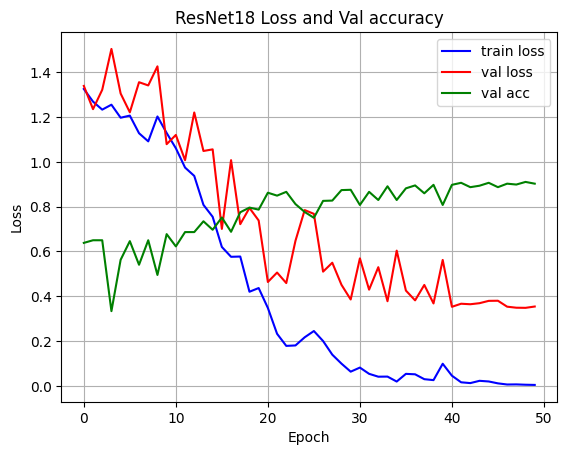

In [6]:
plt.plot(range(0, 50), train_loss_history, color='blue') 
plt.plot(range(0, 50), val_loss_history, color='red') 
#print(val_acc_history)
val_acc_history = torch.Tensor(val_acc_history)
for i in range(0,50):
    val_acc_history[i] = torch.Tensor.cpu(val_acc_history[i])
#val_acc_history = val_acc_history.cpu().data.numpy().argmax()
plt.plot(range(0, 50), val_acc_history, color='green') 
plt.rcParams["figure.figsize"] = (10,6) 
plt.grid() 
plt.xlabel('Epoch') 
plt.ylabel('Loss') 
plt.title('ResNet18 Loss and Val accuracy') 
plt.legend(['train loss','val loss','val acc'])

In [5]:
#load 48 random samples from the dataset and produce confusion matrix and classification report
import seaborn as sns
cm = ConfusionMatrix(task='multiclass',num_classes=7)
testloader = dataloader.DataLoader(valset, batch_size=48,shuffle=True)
best_model_dict = torch.load('best_model91.pt')
#print(best_model_dict)
RN18.load_state_dict(best_model_dict['model_state_dict'])
RN18.eval()
preds = torch.tensor([],dtype=torch.int)
target = torch.tensor([],dtype=torch.int)
for images, labels in testloader:
    #print("next image")
    #print(images.unsqueeze(1))
    images = images.cuda()
    #labels = labels.to(device)
    outputs = RN18(images)
    images = images.detach().cpu()
    del images
    outputs_ = torch.Tensor.cpu(outputs)
    #print(outputs_)
    #print(labels)
    outputs = outputs.detach().cpu()
    del outputs
    preds = torch.cat((preds,outputs_))
    target = torch.cat((target,labels))
    del labels
    #print(outputs)
    break
    torch.cuda.empty_cache()
    print(torch.cuda.memory_allocated())
#print(preds)
#print(target)
matrix = cm(preds,target)

In [16]:
# 48 sample classification report
labels = ['anger','disgust','fear','happiness','neutral','sadness','surprise']
preds_ = preds.detach().numpy()
preds_simple = np.zeros((48,1))
prev_max = 0
for i in range(0,48):
    for j in range(0,7):
        if preds_[i,j] > prev_max:
            prev_max = preds_[i,j]
            preds_simple[i] = j
    prev_max = 0
target_ = target.detach().numpy()
preds_simple = preds_simple[:,0]
#preds_simple
#target_
cr = classification_report(preds_simple,target,target_names=labels)
print(cr)

              precision    recall  f1-score   support

       anger       1.00      1.00      1.00         1
     disgust       1.00      1.00      1.00         2
        fear       1.00      1.00      1.00         2
   happiness       1.00      1.00      1.00         7
     neutral       1.00      1.00      1.00        30
     sadness       1.00      1.00      1.00         2
    surprise       1.00      1.00      1.00         4

    accuracy                           1.00        48
   macro avg       1.00      1.00      1.00        48
weighted avg       1.00      1.00      1.00        48



anger
disgust
fear
happiness
neutral
sadness
surprise


Text(50.722222222222214, 0.5, 'actual label')

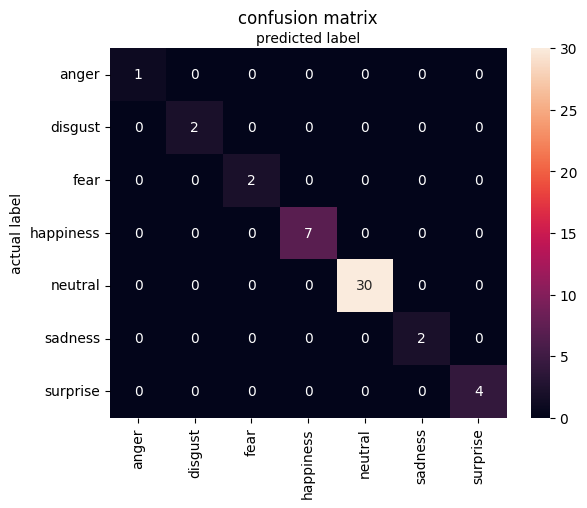

In [17]:
#48 sample confusion matrix
fig,ax = plt.subplots()
conf_matrix = matrix.numpy()
#print(matrix)
labels = ('anger','disgust','fear','happiness','neutral','sadness','surprise')
for i in labels:
    print(i)
df_cm = pd.DataFrame(conf_matrix, index = [i for i in labels],
                     columns = [i for i in labels])
sns.heatmap(df_cm,annot=True)
ax.xaxis.set_label_position('top')
plt.title('confusion matrix')
plt.xlabel('predicted label')
plt.ylabel('actual label')

In [14]:
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())

223269888
